In [3]:
import zipfile
import os

# Extracting dataset
dataset_path = 'mdataset.zip'

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('Deepfake_DATASET')

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)

# Only rescaling for Test Set (no augmentation for test data)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Directory paths
TRAIN_DIR = '/content/Deepfake_DATASET/mdataset/train'
TEST_DIR = '/content/Deepfake_DATASET/mdataset/test'

# Loading Data
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2002 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Build Model using ResNet50
def build_model():
    base_model = ResNet50(
        weights='imagenet',       # Pre-trained weights for better accuracy
        include_top=False,        # Exclude ResNet's final dense layer
        input_shape=(224, 224, 3) # Image shape (224x224 RGB images)
    )

    # Freeze the base model's layers (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False

    # Custom layers on top of ResNet50
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification (Fake/Real)
    ])

    return model

model = build_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      25,690,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training the Model
history = model.fit(
    train_generator,
    epochs=5,                        # Train for 15 epochs (adjust based on results)
    validation_data=test_generator
)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 766s 12s/step - accuracy: 0.5214 - loss: 1.0464 - val_accuracy: 0.6254 - val_loss: 0.6666
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 759s 12s/step - accuracy: 0.5798 - loss: 0.6748 - val_accuracy: 0.6109 - val_loss: 0.6675
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 787s 13s/step - accuracy: 0.5502 - loss: 0.6817 - val_accuracy: 0.5000 - val_loss: 0.6820
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 756s 12s/step - accuracy: 0.5937 - loss: 0.6644 - val_accuracy: 0.6294 - val_loss: 0.6582
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 759s 12s/step - accuracy: 0.6073 - loss: 0.6620 - val_accuracy: 0.6439 - val_loss: 0.6490


In [9]:
# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save Model
model.save('deepfake_detector.h5')
print("Model saved successfully!")


63/63 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step - accuracy: 0.6374 - loss: 0.6492


Test Accuracy: 64.39%
Model saved successfully!


In [13]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load saved model
model = load_model('deepfake_detector.h5')

# Image Prediction Function
def predict_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

    prediction = model.predict(img_array)[0][0]  # Extract prediction score
    if prediction > 0.5:
        print("🔴 The image is FAKE.")
    else:
        print("🟢 The image is REAL.")

# Test an image
predict_image('/content/Deepfake_DATASET/mdataset/test/real/real_103.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
🟢 The image is REAL.


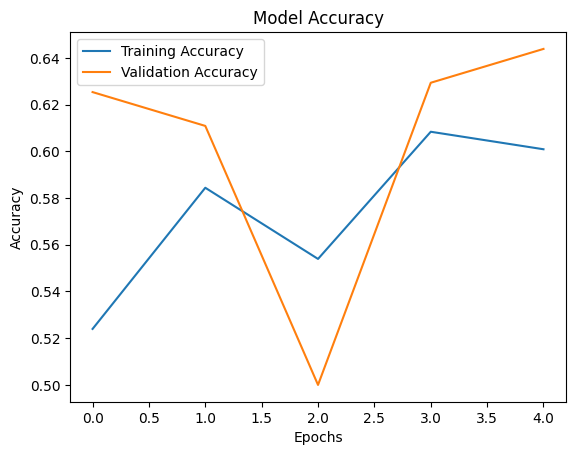

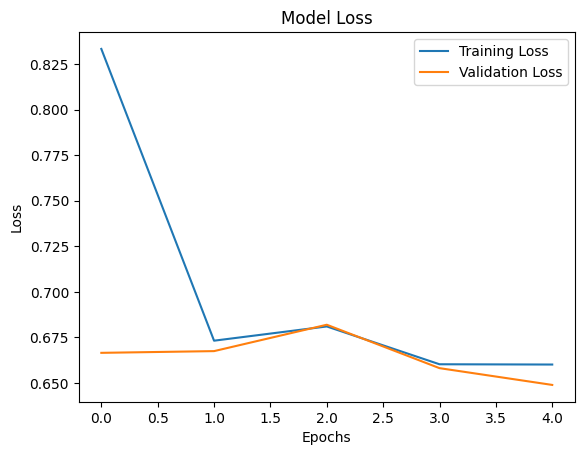

In [14]:
import matplotlib.pyplot as plt

# Plot Training Accuracy & Loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Save model as .h5
model.save('/content/deepfake_detector.h5')
print("✅ Model saved successfully as 'deepfake_detector.h5'")


✅ Model saved successfully as 'deepfake_detector.h5'


In [17]:
from google.colab import files

# Download Model
files.download('/content/deepfake_detector.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>